In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import re
from nltk.stem.porter import *
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [5]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.max_colwidth", 300)

In [6]:
train = pd.read_csv('Data/twitterSentiment_train.csv')
test = pd.read_csv('Data/twitterSentiment_test.csv')

In [7]:
print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [9]:
#let's check non - racist tweets
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [10]:
#let's check racist tweets
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


In [11]:
# let's count tweets for each label
train['label'].value_counts()   # more for non-racist (imbalanced classification)

0    29720
1     2242
Name: label, dtype: int64

Non-racist tweets are more than racist tweets and thus, it is an imbalanced classification problem

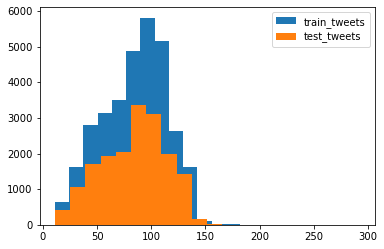

In [12]:
# Let's see the tweet length distribution
tweet_len_train= train['tweet'].str.len()
tweet_len_test = test['tweet'].str.len()

plt.hist(tweet_len_train, bins = 20, label='train_tweets')
plt.hist(tweet_len_test, bins = 20, label='test_tweets')
plt.legend()
plt.show()

# Data cleaning process

In [13]:
# Let's combine training and test data just to make data preprocessing easy
total = train.append(test, ignore_index=True) 
total.shape

(49159, 3)

In [14]:
total.head(3)

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty


In [15]:
# Function to remove unwanted text in the tweets
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text
    

Three steps - 1) Remove twitter handles like @user
              2) Remove punctuations, numbers and special characters
              3) Remove small words like his, all which does not contribute to the analysis
              4) Next, normalize text data to help reduce total unique words without losing any information

In [16]:
total['tidy_tweet'] = np.vectorize(remove_pattern)(total['tweet'], '@[\w]*')   # removing twitter names like @user

In [17]:
total['tidy_tweet'] = total['tidy_tweet'].str.replace('[^a-zA-Z#]', ' ') # any special char except #

In [18]:
total['tidy_tweet'] = total['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) # remove string that are less than 4 char

Text Normalization

In [19]:
tokenized_tweet = total['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [20]:
stemmer  = PorterStemmer()

In [21]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # Stemming

In [22]:
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [23]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '. join(tokenized_tweet[i])
total['tidy_tweet'] = tokenized_tweet    

Now, we have clean tweets and we can explore the data like - common words, common postive/negative words, trends in the dataset

In [24]:
all_words = " ".join([text for text in total['tidy_tweet']])

1 - Let's visualize most Common words with word cloud 

In [25]:
cloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(all_words)

<function matplotlib.pyplot.show(close=None, block=None)>

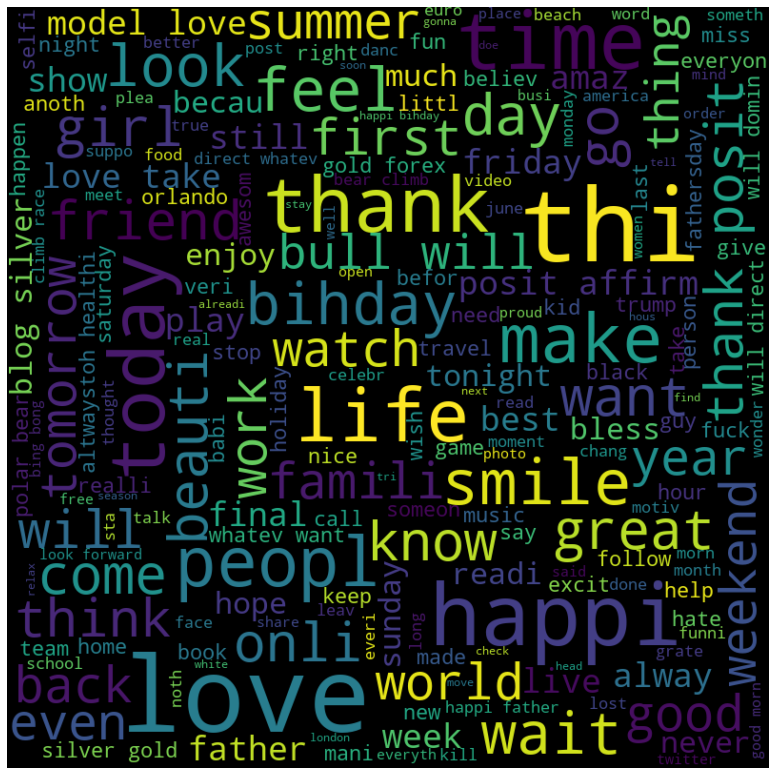

In [26]:
plt.figure(figsize=(14,14))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show

2 - Let's visualize most Common words associated with Non-racist tweets

In [27]:
normal_words = " ".join([text for text in total['tidy_tweet'][total['label']==0]])
cloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(normal_words)

<function matplotlib.pyplot.show(close=None, block=None)>

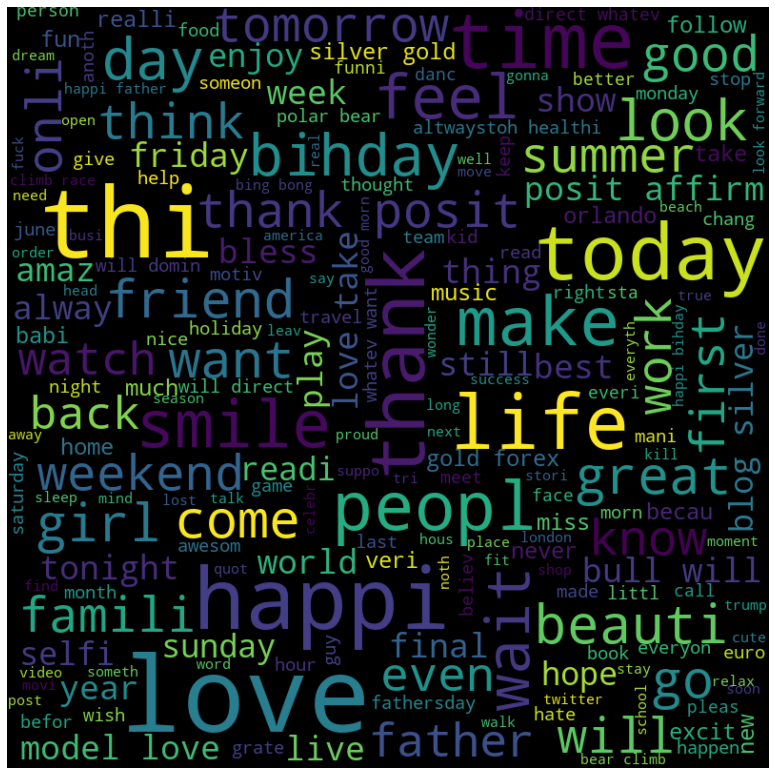

In [28]:
plt.figure(figsize=(14,14))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show

3 - Let's visualize most Common words associated with racist tweets

In [29]:
negative_words = " ".join([text for text in total['tidy_tweet'][total['label']==1]])
cloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(negative_words)

<function matplotlib.pyplot.show(close=None, block=None)>

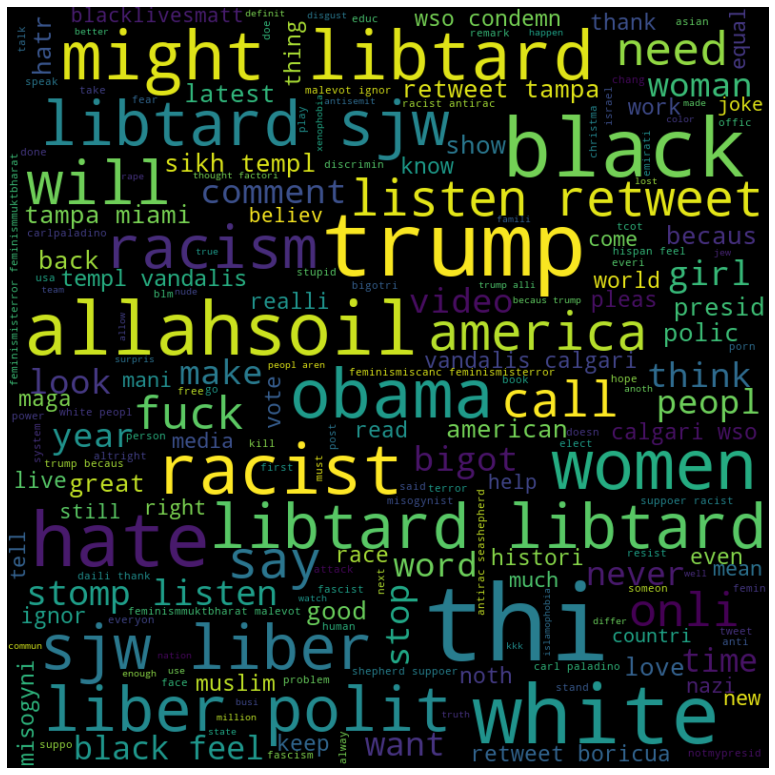

In [30]:
plt.figure(figsize=(14,14))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show

Let's look at hashtags if they can help us in distinguishing the tweets

In [31]:
# function for collecting hashtags 
def hashtag_extract(inp):
    hashtags = []
    for i in inp:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [32]:
# collect positive or non racist hashtags
htags_regular = hashtag_extract(total['tidy_tweet'][total['label'] ==0])

In [33]:
# collect racist hashtags
htags_negative = hashtag_extract(total['tidy_tweet'][total['label'] ==1])

In [34]:
#Unnesting list ---> list of lists to list of strings
htags_regular = sum(htags_regular, [])
htags_negative =sum(htags_negative, [])

In [35]:
# for regular or non-racist tweets
a = nltk.FreqDist(htags_regular)
d = pd.DataFrame( {'Hashtag': list(a.keys()),'Count':list(a.values()) })
print(d.head())
print(len(d))

     Hashtag  Count
0        run     72
1       lyft      2
2  disapoint      1
3   getthank      2
4      model    375
19495


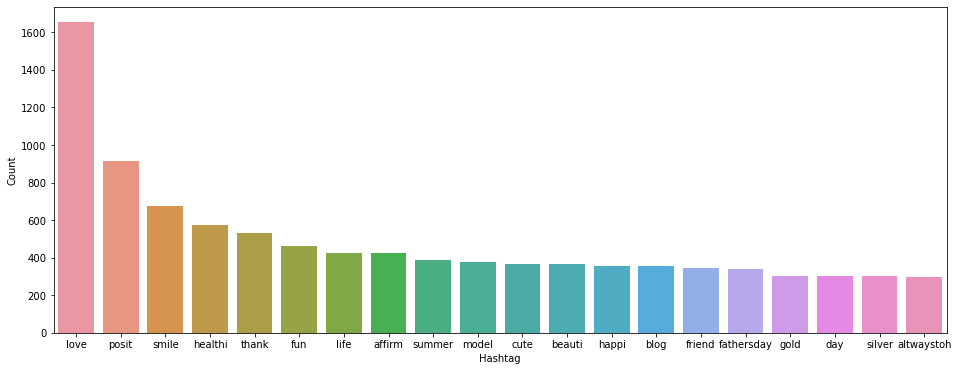

In [36]:
dd = d.nlargest(columns='Count', n = 20)
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=dd, x = 'Hashtag', y = 'Count')
ax.set(ylabel = 'Count')
plt.show()

In [37]:
# for racist tweets, let's check the hashtags
b = nltk.FreqDist(htags_negative)
e = pd.DataFrame( {'Hashtag': list(b.keys()),'Count':list(b.values()) })
print(e.head())
print(len(e))

        Hashtag  Count
0           cnn     10
1      michigan      2
2          tcot     14
3     australia      6
4  opkillingbay      5
1719


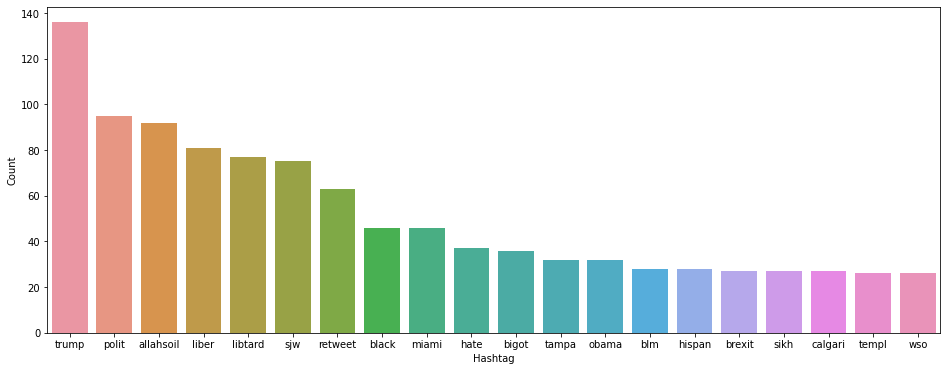

In [38]:
ee = e.nlargest(columns='Count', n = 20)
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=ee, x = 'Hashtag', y = 'Count')
ax.set(ylabel = 'Count')
plt.show()

# We can say hashtags should be kept in mind since as expected most hashtags are able 
#to tell the sentiment of the tweet

Converting text into features now

In [39]:
#Bag of Words Feature model
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words= 'english')
bow = bow_vectorizer.fit_transform(total['tidy_tweet'])
bow.shape

(49159, 1000)

In [40]:
# Term Frequency - inverse document method
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words= 'english')
tfidf = tfidf_vectorizer.fit_transform(total['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [43]:
# extract train and test BoW features
from sklearn.model_selection import train_test_split

train_bow = bow[:31962, :]
test_bow = bow[31962: , :]

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow,train['label'], random_state = 42, test_size=0.3)

# extract train and test tfidf features
train_tfidf = tfidf[:31962, :]
test_tfidf = tfidf[31962: , :]

# to split training data into train and validation data 
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

Fitting Logistic Regression Algorithm

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [45]:
# Let's fit LR on Bag of Words Features
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)
prediction = lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # 0.5303408146300915

#Let's check it on test set
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1]>=0.3
test_pred_int = test_pred_int.astype(np.int)


In [46]:
# Let's fit LR on tfidf Features

lreg.fit(xtrain_tfidf, ytrain)
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:, 1]>=0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)  # 0.5451327433628319

0.5451327433628319

Fitting Support Vector Machine Algorithm 

In [47]:
from sklearn import svm

In [48]:
# on bag of words features
svc = svm.SVC(kernel='linear', C= 1, probability=True)
svc.fit(xtrain_bow, ytrain)
prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:, 1]>=0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)  # 0.5088207985143919

0.5051449953227315

In [49]:
#Let's make prediction on test data 
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:, 1]>= 0.3
test_pred_int = test_pred_int.astype(np.int)

In [50]:
# on Tfidf features
svc = svm.SVC(kernel='linear', C= 1, probability=True)
svc.fit(xtrain_tfidf, ytrain)
prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:, 1]>=0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)  #0.5109489051094891

0.5100182149362478

Fitting Random Forest Algorithm

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# RF on Bag of words features
rf = RandomForestClassifier(n_estimators=400, random_state=11)
rf.fit(xtrain_bow, ytrain)
prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction) # 0.5529225908372828

0.5529225908372828

In [53]:
#Let's make prediction on test data 
test_pred = rf.predict(test_bow)

In [54]:
# RF on TF-IDF features
rf = RandomForestClassifier(n_estimators=400, random_state=11)
rf.fit(xtrain_tfidf, ytrain)
prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction) # 0.562152133580705

0.562152133580705

Fitting XGBoost

Install xgboost
1-Pip install xgboost does not work
2-Download xgboost-1.2.1-cp38-cp38-win32.whl from https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost into "C:\Users\verma\AppData\Local\Temp"
3-C:\Users\verma\AppData\Local\Temp>pip install xgboost-1.2.1-cp38-cp38-win32.whl


In [ ]:
from xgboost import XGBClassifier

In [55]:
# XGBoost on Bag of words features

xgb_model = XGBClassifier(max_depth = 6, n_estimators = 1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)# 0.524770

0.5247706422018349

In [56]:
#Let's make prediction on test data 
test_pred = xgb_model.predict(test_bow)

In [58]:
# XGBoost on TF-IDF features
xgb = XGBClassifier(max_depth = 6, n_estimators = 1000).fit(xtrain_tfidf, ytrain)
prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction) #0.53942

0.5394265232974911